In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import os
import collections
import re 
from imageio import imread, imwrite
from multiprocessing import Pool
import matplotlib.pyplot as plt
import cv2
import gdown
import math
#import matplotlib.pyplot as plt

In [2]:
## Open File and Extract FIDS
def extract_fids(load_list,save_location):
    fids ={}
    for load_location in load_list:
        file = open(load_location, "r").read()
        file.split("FID:")
        occurences = [_.start() for _ in re.finditer("FID:", file)] 
        for occ in occurences:
            key=file[occ-8:occ-2]
            value = file[occ+5:occ+10]
            fids[key]=value
    print(fids)
    with open(save_location, 'w') as fp:
            json.dump(fids, fp)

In [6]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG77834.linse10_output.out"
save_location = "../fids/fids_v3.5.json"
extract_fids([load_location],save_location)

{'005000': '301.9', '010000': '166.3', '015000': '101.8', '020000': '67.21', '025000': '52.32', '030000': '54.83', '035000': '50.44', '040000': '47.16', '045000': '42.90', '050000': '40.05', '055000': '40.57', '060000': '41.45', '065000': '44.26', '070000': '78.75', '075000': '172.1', '080000': '199.7'}


In [4]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG76189.linse2_output.out"
save_location = "/usrhomes/g013/SemanticStyleGAN/fids/fids_v3_2.json"

extract_fids([load_location],save_location)

{'005000': '277.8', '010000': '161.1', '015000': '104.2', '020000': '79.95', '025000': '62.04', '030000': '57.06', '035000': '52.64', '040000': '50.96'}


In [6]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG78195.linse10_output.out"
save_location = "/usrhomes/g013/SemanticStyleGAN/fids/fids_v3.5_2.json"

extract_fids([load_location],save_location)

{'005000': '334.7', '010000': '269.9', '015000': '182.4', '020000': '114.3', '025000': '94.49', '030000': '71.60', '035000': '61.09', '040000': '59.13', '045000': '48.16', '050000': '43.28', '055000': '50.74', '060000': '56.98', '065000': '63.19', '070000': '61.14', '075000': '99.85', '080000': '87.93', '085000': '91.15', '090000': '112.3', '095000': '199.8', '100000': '135.8', '105000': '124.8', '110000': '254.2', '115000': '143.3', '120000': '194.4'}


In [3]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG_v3.7/SSG78580.linse10_output.out"
save_location = "/usrhomes/g013/SemanticStyleGAN/fids/fids_v3.7.json"

extract_fids([load_location],save_location)

{'005000': '279.6', '010000': '110.0', '015000': '64.36', '020000': '48.45', '025000': '35.98', '030000': '30.94', '035000': '28.50', '040000': '26.71', '045000': '24.85', '050000': '23.14', '055000': '24.60', '060000': '21.47', '065000': '21.39', '070000': '21.45', '075000': '25.48', '080000': '22.88', '085000': '22.05', '090000': '24.32', '095000': '27.66', '100000': '27.66', '105000': '39.28', '110000': '40.81', '115000': '39.86'}


In [3]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG_v3.10/SSG78935.linse3_output.out"
save_location = "/usrhomes/g013/SemanticStyleGAN/fids/fids_v3.10.json"

extract_fids([load_location],save_location)

{'005000': '-3533', '010000': '220.1'}


In [3]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG_v3.11/SSG79038.linse3_output.out"
save_location = "/usrhomes/g013/SemanticStyleGAN/fids/fids_v3.11.json"

extract_fids([load_location],save_location)

{'005000': '218.2', '010000': '76.51', '015000': '51.47', '020000': '40.52', '025000': '32.65', '030000': '29.48', '035000': '26.82', '040000': '23.67', '045000': '23.17', '050000': '22.77', '055000': '19.83', '060000': '17.81', '065000': '17.99', '070000': '17.98', '075000': '17.57', '080000': '17.02', '085000': '16.22', '090000': '16.12', '095000': '15.04', '100000': '15.11', '105000': '14.41', '110000': '13.46', '115000': '14.17', '120000': '14.30', '125000': '14.02', '130000': '13.34', '135000': '12.96', '140000': '13.11', '145000': '12.94', '150000': '12.15', '155000': '12.53', '160000': '12.49', '165000': '11.53', '170000': '11.76', '175000': '12.45', '180000': '12.29', '185000': '11.28', '190000': '11.81', '195000': '11.69', '200000': '12.00', '205000': '11.81', '210000': '12.46', '215000': '11.48'}


## Extract Losses

In [7]:
def plot_loss_diff(iterations,g_losses,d_losses,save_location=None):
    d_losses= np.array(d_losses)
    g_losses=np.array(g_losses)
    diff= np.abs(g_losses-d_losses)
    x_keys = iterations
    rang= 20
    max_val = round(max(diff),2)
    min_val = round(min(diff),2)
    step= round((max_val-min_val)/10,2)
    plt.plot(x_keys,diff,c='y',label="loss difference")
    plt.yticks(np.arange(min_val,max_val,step))
    plt.xlabel("Iterations in Thousand")
    plt.ylabel("Loss Values")
    plt.xticks(rotation='vertical')
    plt.legend(loc="upper right")
    if save_location:
            location =Path(save_location)
            plt.savefig(str(location.parent/location.stem)+".png", bbox_inches='tight')
    else:
            plt.show()


In [5]:
def plot_losses(iterations,g_losses,d_losses,save_location=None):
    x_keys = iterations
    rang= 20
    max_val = max(max(g_losses),max(d_losses))
    min_val = min(min(g_losses),min(d_losses))
    step= (max_val-min_val)/20

    plt.plot(x_keys,g_losses,c='b',label="Generator loss")
    plt.plot(x_keys,d_losses,c='g',label="Discriminator loss")
    plt.yticks(np.arange(min_val,max_val,step))
    plt.xlabel("Iterations in Thousand")
    plt.ylabel("Loss Values")
    plt.xticks(rotation='vertical')
    plt.legend(loc="upper right")
    if save_location:
            location =Path(save_location)
            plt.savefig(str(location.parent/location.stem)+".png", bbox_inches='tight')
    else:
            plt.show()


In [6]:

def extract_losses(load_location):
    file = open(load_location, "r").read()
    file.split("\n")
    iterations=[]
    d_losses=[]
    g_losses=[]
    upper_bound=20
    ## Extract Data from CSV
    for line in file.split("\n"):
        if not ("d:" in line and "g:" in line):
            continue
        split_2 = line.split(" ")
        iteration = int(split_2[0][1:-1])
        discriminator_loss = float(split_2[2][:-1])
        generator_loss = float(split_2[4][:-1])
        if generator_loss > upper_bound or discriminator_loss>upper_bound:
            continue
        iterations.append(iteration)
        d_losses.append(discriminator_loss)
        g_losses.append(generator_loss)
    return(iterations,d_losses,g_losses)
def get_losses(load_location,save_location=None,difference=False):
    iterations,d_losses,g_losses=extract_losses(load_location)
    if difference:
        plot_loss_diff(iterations,g_losses,d_losses,save_location)
    else:
        plot_losses(iterations,g_losses,d_losses,save_location)


#occurences = [_.start() for _ in re.finditer("FID:", file)] 

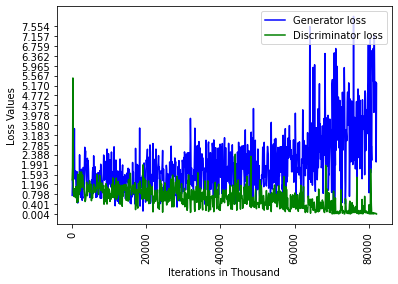

In [10]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG77834.linse10_output.out"
save_location = "/usrhomes/g013/SemanticStyleGAN/fids/loss_v3.5.png"
get_losses(load_location,save_location,difference=False)


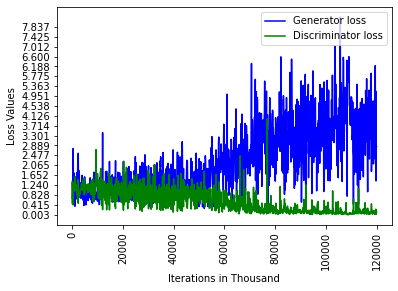

In [11]:
##V3.5_2
# G and D loss are very close
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG78195.linse10_output.out"
get_losses(load_location,difference=False)

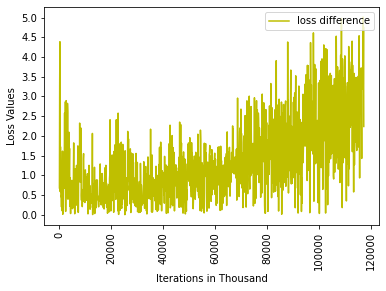

In [14]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG_v3.7/SSG78580.linse10_output.out"
save_location="/usrhomes/g013/SemanticStyleGAN/fids/loss_v3.7.png"
get_losses(load_location,save_location,difference=True)

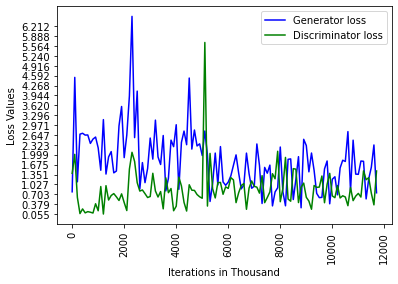

In [7]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG_v3.10/SSG78935.linse3_output.out"
get_losses(load_location,difference=False)

### Computing Average Loss before and After

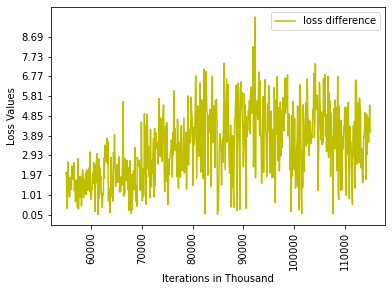

In [10]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/v3.4/SSG77641.linse2_output.out"
get_losses(load_location,difference=True)


In [12]:
#Calculate average losses before and after a certain threshold for both disc or gen.
def calculate_average_before_after(load_location,iteration,max_iterations=None):
    iterations,d_losses,g_losses=extract_losses(load_location) 
    index_max= len(d_losses) if max_iterations==None else iterations.index(max_iterations)
    index=iterations.index(iteration)
    average_before_g= sum(g_losses[:index])/index
    average_after_g=sum(g_losses[index:index_max])/(index_max-index)
    average_before_d= sum(d_losses[:index])/index
    average_after_d=sum(d_losses[index:index_max])/(index_max-index)
    diff_before=abs(average_before_d-average_before_g)
    diff_after=abs(average_after_d-average_after_g)
    print(f"Max iteration available is : {iterations[-1]}")
    print(f"On Average, For Generator the loss went from {average_before_g:.4f} -----> {average_after_g:.4f} ")
    print(f"On Average, For Discriminator the loss went from {average_before_d:.4f} -----> {average_after_d:.4f} ")
    print(f"Diff before iteration {iteration} is :{diff_before:.4f} and after it is {diff_after:.4f}")
    return {
        "average_generator_loss_before":average_before_g,
        "average_generator_loss_after":average_after_g,
        "average_discriminator_loss_before":average_before_d,
        "average_discriminator_loss_after":average_after_d,
        "difference_before":diff_before,
        "difference_after":diff_after,

    }

In [13]:
#load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG78195.linse10_output.out"
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG_v3.7/SSG78580.linse10_output.out"
calculate_average_before_after(load_location,iteration=60000)

Max iteration available is : 117200
On Average, For Generator the loss went from 1.4985 -----> 2.2819 
On Average, For Discriminator the loss went from 0.7742 -----> 0.3984 
Diff before iteration 60000 is :0.7242 and after it is 1.8836


{'average_generator_loss_before': 1.4984691666666665,
 'average_generator_loss_after': 2.281942757417102,
 'average_discriminator_loss_before': 0.7742216666666665,
 'average_discriminator_loss_after': 0.39837993019197226,
 'difference_before': 0.7242475,
 'difference_after': 1.8835628272251297}

In [77]:
res.index(57400)

24